#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
# pipe's mass is different from vessel's mass

In [3]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import scipy
from numpy import linalg as LA

In [4]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [5]:
# from diffeqpy import ode
# from diffeqpy import de

In [6]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [7]:
from sympy import *

In [8]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [9]:
mp = 96 #  (submerged) [kg/m]

In [10]:
node_N = 4

In [11]:
mi = [mp for i in range(node_N)] 

In [12]:
# L - the hull length
# Xg - x-center of gravity
L = 169 # [m]
Xg = 78 # [m]
mn = 123000000 # mass of the vessel, [kg] !!!!!!!!!!!!!!!!!! Solitaire type vessel 

In [13]:
vessel_mass=mn/L # mass over length of vessel

In [14]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [15]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [16]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [17]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [18]:
Irho+=vessel_inertia

In [19]:
# vessel_inertia_coef = vessel_inertia/np.max(diag_Irho)

In [20]:
# vessel_inertia_coef

In [21]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [22]:
diag_DT = 1.5*np.array([1, 1, 1]) 
# diag_DT = 1.5e15*np.array([1, 1, 1]) # [N/m]  , p.99 in [1] !!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [23]:
DT=np.diag(diag_DT) # (35) in [2]

In [24]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [25]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [26]:
CT=np.diag(diag_CT)

In [27]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [28]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [29]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [30]:
rng = np.random.default_rng()

In [31]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [32]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [33]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.34424382,  0.37536905, -0.86057787],
       [-0.86103776, -0.23921084, -0.44876737],
       [-0.37431294,  0.89547543,  0.24086007]])

In [34]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001258


In [35]:
Ret

array([[[ 0.34424382,  0.37536905, -0.86057787],
        [-0.86103776, -0.23921084, -0.44876737],
        [-0.37431294,  0.89547543,  0.24086007]],

       [[ 0.85409774, -0.38102347, -0.35403132],
        [ 0.438417  ,  0.16118866,  0.88419949],
        [-0.27983492, -0.91040614,  0.30471804]],

       [[ 0.8310957 , -0.44198735,  0.33753091],
        [-0.02008635,  0.58267602,  0.81245628],
        [-0.55576657, -0.68200868,  0.47538162]],

       [[ 0.7638243 ,  0.61090953, -0.20823544],
        [-0.62783004,  0.77808777, -0.02022039],
        [ 0.14967262,  0.14618129,  0.97786969]]])

In [36]:
Ret.shape

(4, 3, 3)

In [37]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [38]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [39]:
np.abs(dx)*dx

array([-2.38090574,  0.2322026 ,  0.97494672,  0.03104824])

In [40]:
C1(dx,dy,dz,Ret)

array([[-0.7058735 , -0.14683992,  2.68002184,  1.62973025],
       [-0.41599092, -0.09608558,  2.10899255,  0.7329206 ],
       [ 2.28853419, -0.48151246, -0.86317861,  2.76969028]])

In [41]:
C1(dx,dy,dz,Ret).shape

(3, 4)

In [42]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000389


In [43]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [44]:
1/2*d0*qw*np.dot(DT,C1(dx,dy,dz,Ret).T[0])*9.81

array([-4051.03196225, -2387.38603501, 13133.97535513])

In [45]:
fD(dx,dy,dz,DT,Ret)

array([[-4051.03196225,  -842.71930622, 15380.73629326,  9353.07721566],
       [-2387.38603501,  -551.43842619, 12103.57980011,  4206.25621859],
       [13133.97535513, -2763.41632077, -4953.81134006, 15895.34649571]])

In [46]:
fD(dx,dy,dz,DT,Ret).T

array([[-4051.03196225, -2387.38603501, 13133.97535513],
       [ -842.71930622,  -551.43842619, -2763.41632077],
       [15380.73629326, 12103.57980011, -4953.81134006],
       [ 9353.07721566,  4206.25621859, 15895.34649571]])

In [47]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000416


In [48]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [49]:
I=np.identity(3)

In [50]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000403


In [51]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [52]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [53]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [54]:
DR=np.diag(diag_DR) 

In [55]:
dI= 0.69# Inner diameter of pipe, [m]

In [56]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [57]:
Ar

0.08091250419136858

In [58]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [59]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [60]:
# # not checked 
# def k_sigma(hi,d0,fg_e):
#     ans=[]
#     for it in hi:
#         if it<0:
#             ans.append(0)
#         elif 0<=it<=d0/20:
#             ans.append(np.float32(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
#         else:
#             ans.append(np.float32(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))     
#     return np.array(ans).reshape(node_N,1)   

In [61]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [62]:
# # not checked
# def hi(x,y,z,d0):
#     return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [63]:
# startTime1 = datetime.now()
# hi(x,y,z,d0)
# print(datetime.now() - startTime1)

In [64]:
# k_sigma(hi(x,y,z,d0),d0,fg_e)

In [65]:
# startTime1 = datetime.now()
# k_sigma(hi(x,y,z,d0),d0,fg_e)
# print(datetime.now() - startTime1)

In [66]:
# # TODO: force shoud be acting only at nodes that are in contact with the seabed
# # not checked
# def sigma(x,y,z):
#     return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [67]:
# startTime1 = datetime.now()
# sigma(x,y,z)
# print(datetime.now() - startTime1)

In [68]:
def Re_b(Ret):
#     return np.dot(Ret, Rb_t ) # (5) in[3]
    return Ret

In [69]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000077


In [70]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [71]:
phi(x,y,z,Ret,None)

array([[  51.09986654, -137.11034401,  -79.09364003],
       [ -24.04460429,   74.17969686,  -97.80902516],
       [  38.95701443,   54.56495418, -125.99775394],
       [   0.54339504,  150.15278213,  134.695727  ]])

In [72]:
# def d_s(da,db,dc,x,y,z):

#     ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
#                  +np.diff(z,prepend=z[0])**2)
#     ds[ds == 0] = 1
#     return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [73]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.000187


In [74]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [75]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [76]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000508


In [77]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [78]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.000604


In [79]:
ωe(φ,θ,ψ,None,None)

array([[ 0.88638004, -0.30629204,  0.72830134],
       [-1.20707984,  0.03484034, -0.31075084],
       [-0.89696179,  0.76615647,  0.58385574],
       [ 0.16067187, -0.19582366, -0.65538643]])

In [80]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    K=np.apply_along_axis(S, 1, omega)
#     print('fun',fun)
#     print('K',K)
#     print('ans',np.einsum('ijk,ik->ij',K,fun).T)

    return np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T



In [81]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 124.08340635,   19.64370302, -128.39205695,   72.03148855],
       [ 107.32312706, -110.5914255 ,  -90.26989593,  -21.99794734],
       [-105.88039742,  -88.7030921 ,  -78.7898473 ,   24.23173819]])

In [82]:
# def d_s(f,a,b,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(b,prepend=b[0])**2
# #                  +np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(b)**2+np.diff(c)**2)
#     ds[ds == 0] = 1
#     fun = f(a,b,c,Ret)
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     return np.insert(ans, -1, 0.8*ans[:,-1], axis=1)

In [83]:
# def d_s(f,a,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(c)**2)
# #     ds[ds == 0] = 1
#     fun = f(a,c,Ret)
# #     ans=(np.diff(fun,prepend=fun[0].reshape(1,2),axis=0) / ds.reshape(node_N,1)).T
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     np.insert(ans, -1, ans[:,-1], axis=1)
#     return np.insert(ans, -1, 1.1*ans[:,-1], axis=1)

In [84]:
# d_s(phi,x,y,z,Ret)

In [85]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001039


In [86]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B-
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze())

In [87]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [88]:
# sigma(x,y,z)

In [89]:
ne_(dx,dy,dz,DT,Ret)

array([[  4051.03196225,    842.71930622, -15380.73629326,
         -9353.07721566],
       [  2387.38603501,    551.43842619, -12103.57980011,
         -4206.25621859],
       [-13262.13989736,   2635.25177854,   4825.64679783,
        -16023.51103794]])

In [90]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [91]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.000591


In [92]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 1.46635620e+10,  6.19049567e+09, -6.12078483e+09],
       [ 1.37066966e+10, -2.88475339e+09, -8.21037177e+09],
       [-8.92570243e+10, -3.06408327e+10, -1.76799384e+10],
       [ 4.15795212e+10, -1.29379094e+10,  2.30279724e+10]])

In [93]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000405


In [94]:
Re_b(Ret).shape

(4, 3, 3)

In [95]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans
#     tmp=[1 for i in range(node_N)]
#     tmp[-1]=1e13
#     print(ans)
#     return ans*np.array(tmp).reshape(node_N,1)
#     return np.einsum("ijk,ip->ijk", ans, np.array(tmp).reshape(node_N,1))

In [96]:
Irho_e(Ret)

array([[[1.14699205e+11, 1.36378222e+11, 7.16817261e+11],
        [7.17583589e+11, 5.53847016e+10, 1.94926397e+11],
        [1.35611894e+11, 7.76131764e+11, 5.61510291e+10]],

       [[7.06062668e+11, 1.40517868e+11, 1.21314151e+11],
        [1.86038525e+11, 2.51476304e+10, 7.56708532e+11],
        [7.57934946e+10, 8.02229189e+11, 8.98720038e+10]],

       [[6.68544280e+11, 1.89080957e+11, 1.10269451e+11],
        [3.90508160e+08, 3.28611221e+11, 6.38892958e+11],
        [2.98959900e+11, 4.50202510e+11, 2.18732278e+11]],

       [[5.64696430e+11, 3.61228411e+11, 4.19698463e+10],
        [3.81515585e+11, 5.85983365e+11, 3.95737575e+08],
        [2.16826722e+10, 2.06829117e+10, 9.25529104e+11]]])

In [97]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000113


In [98]:
# def Π_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
#     return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
#                   [0,1,-np.sin(φ)],
#                   [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [99]:
# def Π(a,b,c):
#     xyz=np.stack((a,b,c), axis=1)
  
#     return np.apply_along_axis(Π_, 1, xyz)
    

In [100]:
# startTime1 = datetime.now()
# Π(φ,θ,ψ).shape
# print(datetime.now() - startTime1)

In [101]:
# def ωe(φ,θ,ψ, dummy):  # (100) in [2]
#     A=Π(φ,θ,ψ)
#     B=np.vstack([φ,θ,ψ])
#     return np.einsum('ijk,ik->ij',A,B.T)

In [102]:
# startTime1 = datetime.now()
# ωe(φ,θ,ψ,None)
# print(datetime.now() - startTime1)

In [103]:
# ωe(φ,θ,ψ,None)

In [104]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [105]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [106]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega.astype(np.float32))
 
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [107]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.000849


In [108]:
d_me_

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [109]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [110]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [111]:
ne_(dx,dy,dz,DT,Ret)

array([[  4051.03196225,    842.71930622, -15380.73629326,
         -9353.07721566],
       [  2387.38603501,    551.43842619, -12103.57980011,
         -4206.25621859],
       [-13262.13989736,   2635.25177854,   4825.64679783,
        -16023.51103794]])

In [112]:
C=ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [113]:
Re_b(Ret).shape

(4, 3, 3)

In [114]:
ne_(dx,dy,dz,DT, Ret).T

array([[  4051.03196225,   2387.38603501, -13262.13989736],
       [   842.71930622,    551.43842619,   2635.25177854],
       [-15380.73629326, -12103.57980011,   4825.64679783],
       [ -9353.07721566,  -4206.25621859, -16023.51103794]])

In [115]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([-18.84682259, 110.16441736, 100.50674073, 136.85401125]),
 array([ -1.49526505,  44.29801852,  -2.41618016, 128.56557139]),
 array([-1.54301839,  0.48187405,  0.98739391,  0.17620512]),
 numpy.ndarray,
 array([0.16671549, 0.56254748, 1.33980639, 1.10854318]))

In [116]:
ne_(dx,dy,dz,DT,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(dx,dy,dz,DT,Ret).T.astype(np.float32))

array([[ 17754.82938459,   4279.82151254, -15834.96795144],
       [   419.41134725,   3339.8747451 ,   2700.4052935 ],
       [-21185.1657805 , -14926.47560248,  23922.51635868],
       [-15730.16410596,  -1282.94840276, -33707.19208345]])

In [117]:
ne_(dx,dy,dz,DT,Ret).T

array([[  4051.03196225,   2387.38603501, -13262.13989736],
       [   842.71930622,    551.43842619,   2635.25177854],
       [-15380.73629326, -12103.57980011,   4825.64679783],
       [ -9353.07721566,  -4206.25621859, -16023.51103794]])

### Vessel

In [118]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [119]:
V=VesselSemisub()

In [120]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [121]:
tau_force = V.tau(η,dη, ddη)

In [122]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [123]:
class VesselOtter: 
    
    def __init__(
        self, 
        controlSystem="stepInput", 
        r = 0, 
        V_current = 0, 
        beta_current = 0,
        tau_X = 120
    ):
        
        # Constants
        D2R = math.pi / 180     # deg2rad
        self.g = 9.81           # acceleration of gravity (m/s^2)
        rho = 1026              # density of water (kg/m^3)

        if controlSystem == "headingAutopilot":
            self.controlDescription = (
                "Heading autopilot, psi_d = "
                + str(r)
                + " deg"
                )
        else:
            self.controlDescription = "Step inputs for n1 and n2"
            controlSystem = "stepInput"

        self.ref = r
        self.V_c = V_current
        self.beta_c = beta_current * D2R
        self.controlMode = controlSystem
        self.tauX = tau_X  # surge force (N)

        # Initialize the Otter USV model
        self.T_n = 1.0  # propeller time constants (s)
        self.L = 2.0    # Length (m)
        self.B = 1.08   # beam (m)
        self.nu = np.array([0, 0, 0, 0, 0, 0], float)  # velocity vector
        self.u_actual = np.array([0, 0], float)  # propeller revolution states
        self.name = "Otter USV (see 'otter.py' for more details)"

        self.controls = [
            "Left propeller shaft speed (rad/s)",
            "Right propeller shaft speed (rad/s)"
        ]
        self.dimU = len(self.controls)

        # Vehicle parameters
        m = 55.0                                 # mass (kg)
        self.mp = 25.0                           # Payload (kg)
        self.m_total = m + self.mp
        self.rp = np.array([0.05, 0, -0.35], float) # location of payload (m)
        rg = np.array([0.2, 0, -0.2], float)     # CG for hull only (m)
        rg = (m * rg + self.mp * self.rp) / (m + self.mp)  # CG corrected for payload
        self.S_rg = Smtrx(rg)
        self.H_rg = Hmtrx(rg)
        self.S_rp = Smtrx(self.rp)

        R44 = 0.4 * self.B  # radii of gyration (m)
        R55 = 0.25 * self.L
        R66 = 0.25 * self.L
        T_yaw = 1.0         # time constant in yaw (s)
        Umax = 6 * 0.5144   # max forward speed (m/s)

        # Data for one pontoon
        self.B_pont = 0.25  # beam of one pontoon (m)
        y_pont = 0.395      # distance from centerline to waterline centroid (m)
        Cw_pont = 0.75      # waterline area coefficient (-)
        Cb_pont = 0.4       # block coefficient, computed from m = 55 kg

        # Inertia dyadic, volume displacement and draft
        nabla = (m + self.mp) / rho  # volume
        self.T = nabla / (2 * Cb_pont * self.B_pont * self.L)  # draft
        Ig_CG = m * np.diag(np.array([R44 ** 2, R55 ** 2, R66 ** 2]))
        self.Ig = Ig_CG - m * self.S_rg @ self.S_rg - self.mp * self.S_rp @ self.S_rp

        # Experimental propeller data including lever arms
        self.l1 = -y_pont  # lever arm, left propeller (m)
        self.l2 = y_pont  # lever arm, right propeller (m)
        self.k_pos = 0.02216 / 2  # Positive Bollard, one propeller
        self.k_neg = 0.01289 / 2  # Negative Bollard, one propeller
        self.n_max = math.sqrt((0.5 * 24.4 * self.g) / self.k_pos)  # max. prop. rev.
        self.n_min = -math.sqrt((0.5 * 13.6 * self.g) / self.k_neg) # min. prop. rev.

        # MRB_CG = [ (m+mp) * I3  O3      (Fossen 2021, Chapter 3)
        #               O3       Ig ]
        MRB_CG = np.zeros((6, 6))
        MRB_CG[0:3, 0:3] = (m + self.mp) * np.identity(3)
        MRB_CG[3:6, 3:6] = self.Ig
        MRB = self.H_rg.T @ MRB_CG @ self.H_rg
        

        # Hydrodynamic added mass (best practice)
        Xudot = -0.1 * m
        Yvdot = -1.5 * m
        Zwdot = -1.0 * m
        Kpdot = -0.2 * self.Ig[0, 0]
        Mqdot = -0.8 * self.Ig[1, 1]
        Nrdot = -1.7 * self.Ig[2, 2]

        self.MA = -np.diag([Xudot, Yvdot, Zwdot, Kpdot, Mqdot, Nrdot])

        # System mass matrix
        self.M = MRB + self.MA
        self.Minv = np.linalg.inv(self.M.astype(np.float32))

        # Hydrostatic quantities (Fossen 2021, Chapter 4)
        Aw_pont = Cw_pont * self.L * self.B_pont  # waterline area, one pontoon
        I_T = (
            2
            * (1 / 12)
            * self.L
            * self.B_pont ** 3
            * (6 * Cw_pont ** 3 / ((1 + Cw_pont) * (1 + 2 * Cw_pont)))
            + 2 * Aw_pont * y_pont ** 2
        )
        I_L = 0.8 * 2 * (1 / 12) * self.B_pont * self.L ** 3
        KB = (1 / 3) * (5 * self.T / 2 - 0.5 * nabla / (self.L * self.B_pont))
        BM_T = I_T / nabla  # BM values
        BM_L = I_L / nabla
        KM_T = KB + BM_T    # KM values
        KM_L = KB + BM_L
        KG = self.T - rg[2]
        GM_T = KM_T - KG    # GM values
        GM_L = KM_L - KG

        G33 = rho * self.g * (2 * Aw_pont)  # spring stiffness
        G44 = rho * self.g * nabla * GM_T
        G55 = rho * self.g * nabla * GM_L
        G_CF = np.diag([0, 0, G33, G44, G55, 0])  # spring stiff. matrix in CF
        LCF = -0.2
        H = Hmtrx(np.array([LCF, 0.0, 0.0]))  # transform G_CF from CF to CO
        self.G = H.T @ G_CF @ H

        # Natural frequencies
        w3 = math.sqrt(G33 / self.M[2, 2])
        w4 = math.sqrt(G44 / self.M[3, 3])
        w5 = math.sqrt(G55 / self.M[4, 4])

        # Linear damping terms (hydrodynamic derivatives)
        Xu = -24.4 *self. g / Umax  # specified using the maximum speed
        Yv = 0
        Zw = -2 * 0.3 * w3 * self.M[2, 2]  # specified using relative damping
        Kp = -2 * 0.2 * w4 * self.M[3, 3]
        Mq = -2 * 0.4 * w5 * self.M[4, 4]
        Nr = -self.M[5, 5] / T_yaw  # specified by the time constant T_yaw

        self.D = -np.diag([Xu, Yv, Zw, Kp, Mq, Nr])

        # Propeller configuration/input matrix
        B = self.k_pos * np.array([[1, 1], [-self.l1, -self.l2]])
        self.Binv = np.linalg.inv(B.astype(np.float32))

        # Heading autopilot
        self.e_int = 0  # integral state
        self.wn = 1.2  # PID pole placement
        self.zeta = 0.8

        # Reference model
        self.r_max = 10 * math.pi / 180  # maximum yaw rate
        self.psi_d = 0  # angle, angular rate and angular acc. states
        self.r_d = 0
        self.a_d = 0
        self.wn_d = self.wn / 5  # desired natural frequency in yaw
        self.zeta_d = 1  # desired relative damping ratio
    
    
    def eq_left(self,η, dη):
        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA

        return (np.matmul(self.D, dη) + np.matmul(C, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):

        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.matmul(C, dη)+ np.dot(self.G,η))
    

In [124]:
# V=VesselOtter()

In [125]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [126]:
tau_force = V.tau(η,dη, ddη)

In [127]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [128]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [129]:
# V=VesselSemisub()

In [130]:
# wave_force=9e6
# wave_force=9e3
# wave_force=0
kp, kd=1.95e4,1.5e4
# kp,kd=1.95e2, 1.5e2
# kp,kd=1.95e8, 1.5e8
# kp,kd=1.95, 1.5
wave_coef=1
# kp,kd=1.95e16, 1.5e16

In [131]:
def Fx(x,dx, z,dz, t, kp, kd, x_ref = 0, dx_ref=0, z_ref = 0, dz_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)-kp*(z-z_ref) - kd*(dz-dz_ref)

In [132]:
Hs = 2.5 # significant wave height in m

In [133]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [134]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [135]:
η

array([0.1, 0.3, 0.4, 0.5, 0.6, 0.7])

In [136]:
def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0, z_ref = 0, dz_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
    F=(np.array([-Fx(x,dx,z,dz,time, kp, kd, x_ref, dx_ref, z_ref, dz_ref),0,0])
       +wave_coef*np.array([0,0,wave_force(Hs,d0,qw)])*np.sin(2*np.pi/Tp*time+1)
      ).T
#     Ret=Re_t_([φ,θ,ψ])
    
#     ans=np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)
    ans=np.concatenate( [F,[0,0,0]], axis=0)
#     ans[2]=0 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    return ans

In [137]:
# for i in range(100):
print(tau(η, dη, wave_coef, kp, kd,3))

[9750.            0.         7283.67179881    0.            0.
    0.        ]


### Static solution

In [138]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [139]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [140]:
Fx_0=82945396

In [141]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [142]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [143]:
Ws

array([941.76, 941.76, 941.76, 941.76])

In [144]:
delta_x=horizontal_length/(node_N-1)

In [145]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [146]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

In [147]:
length_p

[3685.0342622414496, 3691.484223043134, 3704.395427539594]

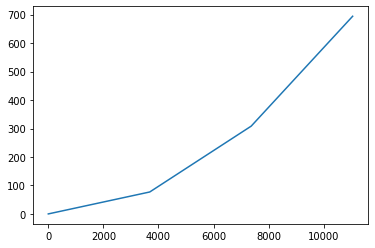

In [148]:
plt.plot(x0, z0)
plt.show()

In [149]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [150]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)

In [151]:
Re_b(Ret),Ws

(array([[[ 0.34424382,  0.37536905, -0.86057787],
         [-0.86103776, -0.23921084, -0.44876737],
         [-0.37431294,  0.89547543,  0.24086007]],
 
        [[ 0.85409774, -0.38102347, -0.35403132],
         [ 0.438417  ,  0.16118866,  0.88419949],
         [-0.27983492, -0.91040614,  0.30471804]],
 
        [[ 0.8310957 , -0.44198735,  0.33753091],
         [-0.02008635,  0.58267602,  0.81245628],
         [-0.55576657, -0.68200868,  0.47538162]],
 
        [[ 0.7638243 ,  0.61090953, -0.20823544],
         [-0.62783004,  0.77808777, -0.02022039],
         [ 0.14967262,  0.14618129,  0.97786969]]]),
 array([941.76, 941.76, 941.76, 941.76]))

In [152]:
np.einsum('it,ijk->ijk',Ws.reshape(node_N,1),Re_b(Ret))

array([[[ 324.19505864,  353.50755411, -810.45781552],
        [-810.89091767, -225.27920117, -422.6311616 ],
        [-352.5129518 ,  843.32294426,  226.83237887]],

       [[ 804.35508572, -358.83265901, -333.412532  ],
        [ 412.88359823,  151.80103113,  832.70371613],
        [-263.53733699, -857.38408393,  286.97125682]],

       [[ 782.69268681, -416.24600952,  317.87311175],
        [ -18.91652001,  548.74096392,  765.1388223 ],
        [-523.39872075, -642.28849568,  447.69539314]],

       [[ 719.33916821,  575.33015553, -196.10780406],
        [-591.2652148 ,  732.77194049,  -19.04275726],
        [ 140.95568259,  137.66769035,  920.91856327]]])

In [153]:
np.einsum('i,ijk->ijk',Ws,Re_b(Ret))

array([[[ 324.19505864,  353.50755411, -810.45781552],
        [-810.89091767, -225.27920117, -422.6311616 ],
        [-352.5129518 ,  843.32294426,  226.83237887]],

       [[ 804.35508572, -358.83265901, -333.412532  ],
        [ 412.88359823,  151.80103113,  832.70371613],
        [-263.53733699, -857.38408393,  286.97125682]],

       [[ 782.69268681, -416.24600952,  317.87311175],
        [ -18.91652001,  548.74096392,  765.1388223 ],
        [-523.39872075, -642.28849568,  447.69539314]],

       [[ 719.33916821,  575.33015553, -196.10780406],
        [-591.2652148 ,  732.77194049,  -19.04275726],
        [ 140.95568259,  137.66769035,  920.91856327]]])

In [154]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])

    
    
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]

#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
    Z1 = d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
#     ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',Ws,Re_b(Ret)),Z).T 
#     ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
#     tmp=phi(ddx_phi,ddy_phi, ddz_phi, Ret)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
############################################################    
#     ans_x=[]
#     ans_y=[]
#     ans_z=[]
#     RRRR=Re_b(Ret)
#     for i in range(len(RRRR)):
#         a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))


#############
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans
    

In [155]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [156]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [157]:
root

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [158]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [159]:
x0

[0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162]

In [160]:
x0_

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446])

In [161]:
z0

[0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863]

In [162]:
z0_

array([  0.        ,  77.06804645, 308.4070593 , 694.42189511])

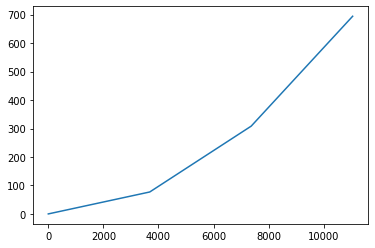

In [163]:
plt.plot(x0_, z0_)
plt.show()

In [164]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=np.array([0,0,0,0.1])
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=np.array([0,0,0,0.1])

In [165]:
# q0[10*node_N]=q0[8*node_N]=0

In [166]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

### Vessle Sim

In [167]:
sampleTime = 0.01                 # sample time [seconds]
N = 5000                         # number of samples

In [168]:
vehicle=semisub('DPcontrol',10.,-10.,40.0,0,0) 

In [169]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [170]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=0.01

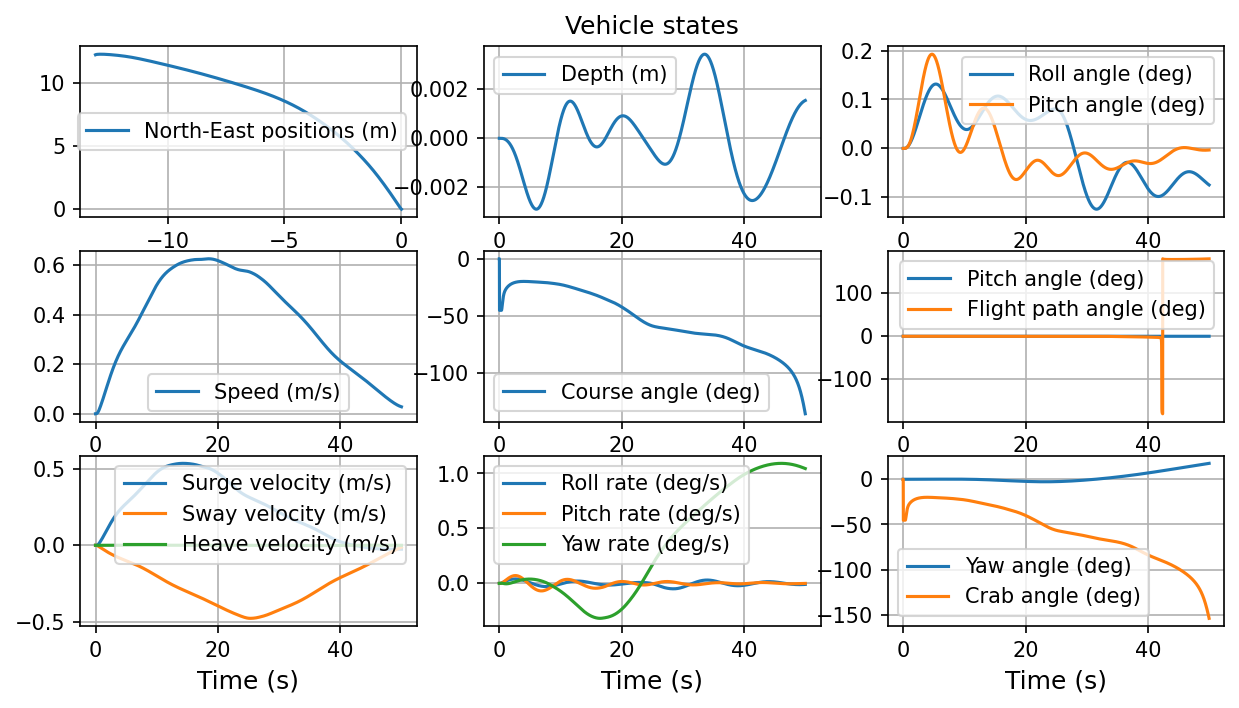

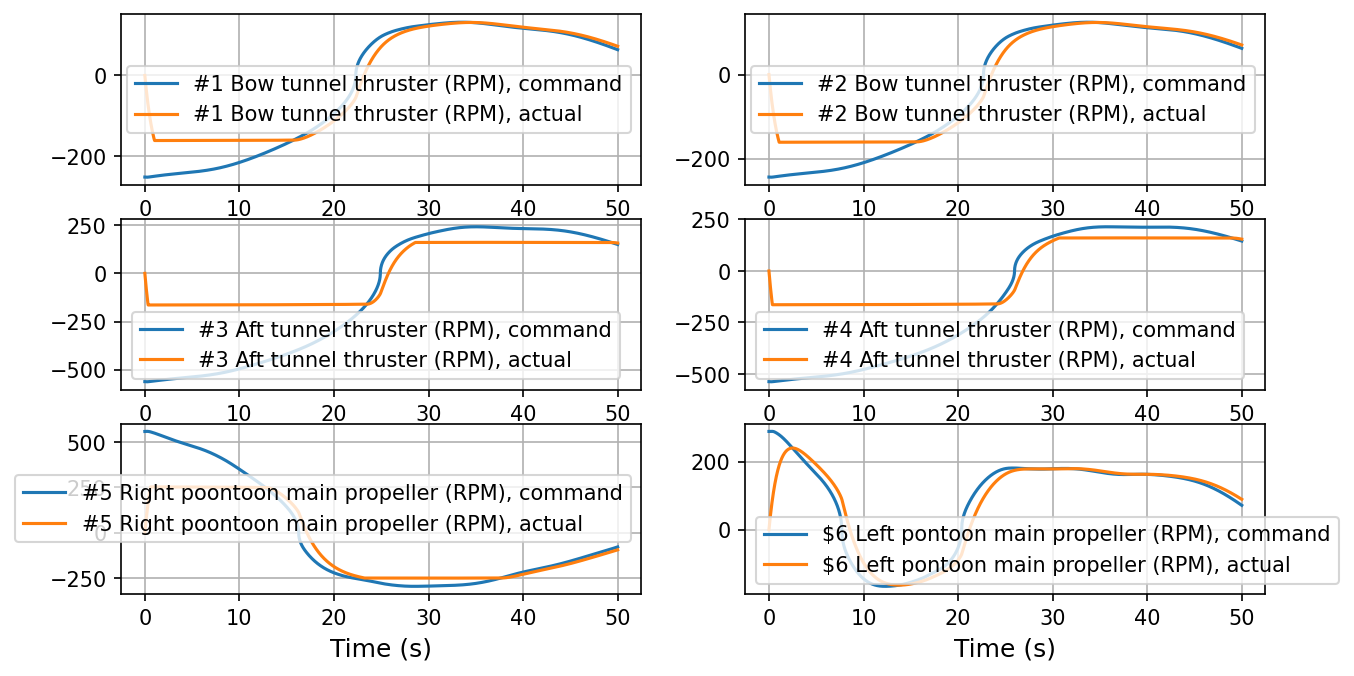

In [171]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [172]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

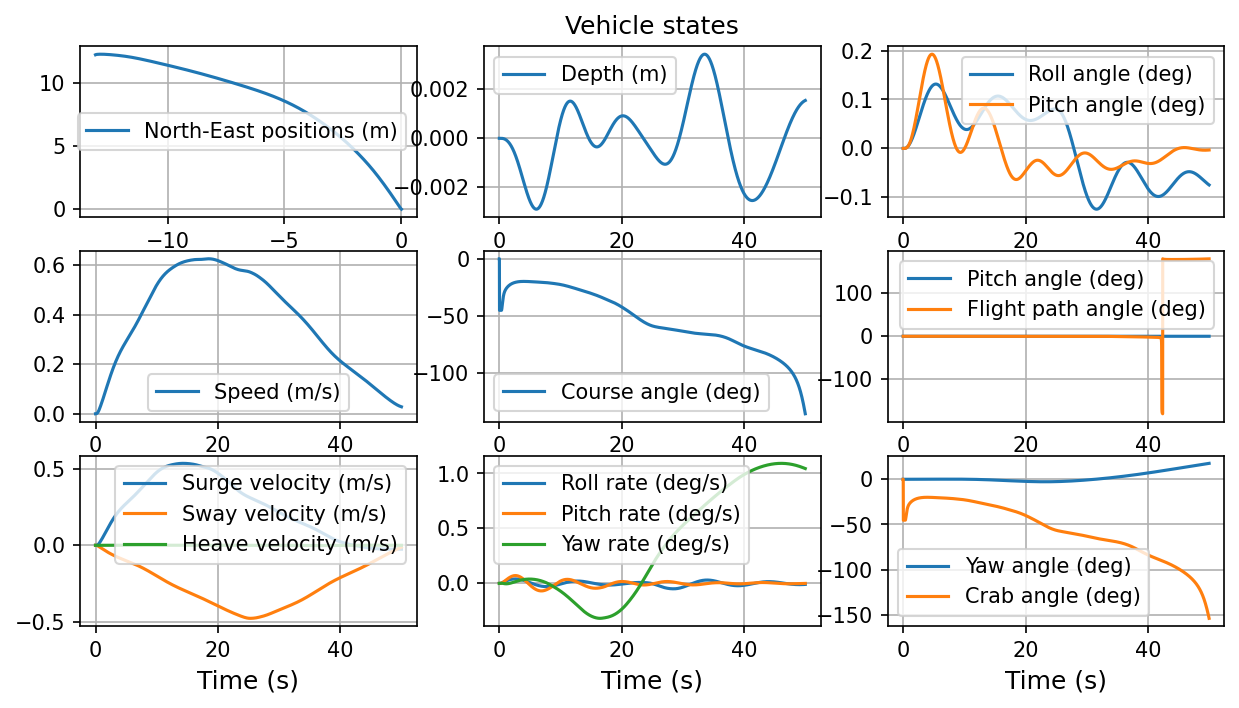

In [173]:
plotVehicleStates(simTime, simData, 3)

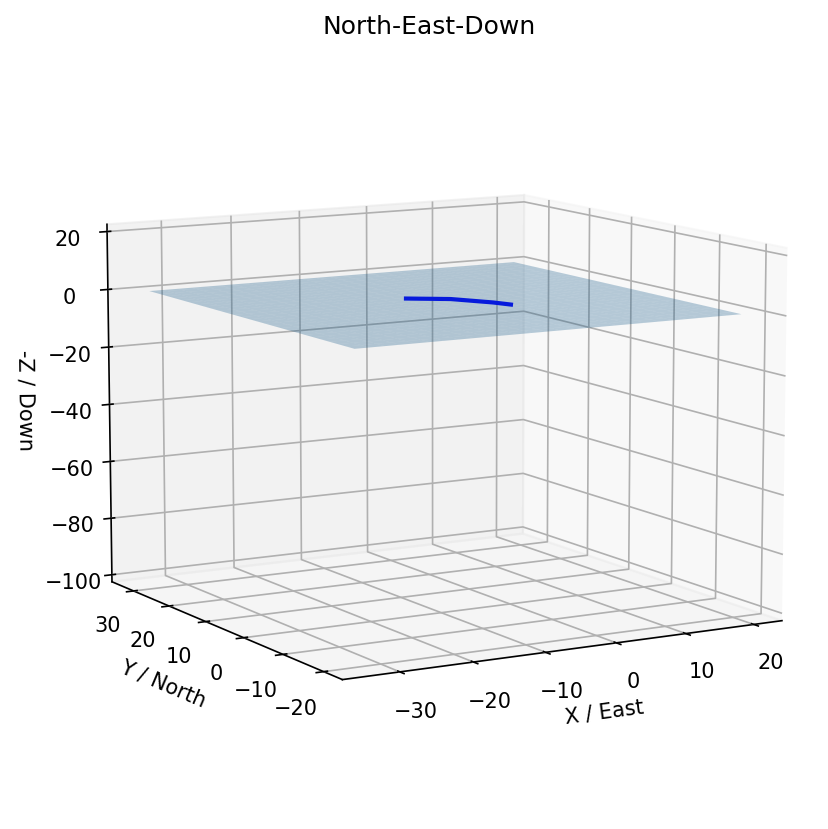

In [174]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [175]:
# diff=np.diff(simData,axis=0)
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### Dynamics

In [176]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
#     print(t)
     
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) #!!!!!!!!!!!!!!!!!!!!!
#     print(simTime[idx])

    # State vectors
    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
#     x[-1]=x_ve+x0_[-1]
#     y[-1]=y_ve
#     z[-1]=z_ve+z0_[-1]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
#     du_ve=diff[:, 6][idx]/sampleTime
#     dv_ve = diff[:, 7][idx]/sampleTime
#     dw_ve = diff[:, 8][idx]/sampleTime
#     dp_ve = diff[:, 9][idx]/sampleTime
#     dq_ve = diff[:, 10][idx]/sampleTime
#     dr_ve = diff[:, 11][idx]/sampleTime
    
    
  
    
    η=np.array([x_ve, y_ve,  z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#       n = DPcontrol(eta,nu,sampleTime)
    
#     ddη=np.array([du_ve, dv_ve, dw_ve, dp_ve, dq_ve, dr_ve])
    
    
#     x[-1]=x0[-1]+10*np.sin(t)
#     x[-1]=x0_[-1]+100*np.sin(t)
#     y[-1]+=5*np.cos(t)
#     z[-1]=z0[-1]+2.5*np.sin(t)
#    z[-1]=z0_[-1]+2.5*np.sin(t)

#     x[0]=0
#     y[0]=0
#     z[0]=0

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
#     dx[0]=0
#     dy[0]=0
#     dz[0]=0

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
#     dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)
#     hack =1
#     hack3=1
    
#     # PD controller after 30 sec
    if t<2:
        ddη=np.linalg.lstsq(V.M.astype(np.float32), -left.astype(np.float32) 
                            + tau(η, dη, wave_coef, 0, 0, t).astype(np.float32)
                            , rcond=None)[0]
    else:
        ddη=np.linalg.lstsq(V.M.astype(np.float32), -left.astype(np.float32) 
                            + tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
                            , rcond=None)[0]
#     print('ddη', ddη)
 
    tau_force = V.tau(η,dη,ddη).astype(np.float32)
#     tau_force =tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
#     tau_force = hack*tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)
#     tau_force = hack*tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]
#     Z0=tau_force[:3]
#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     print(Ret,Z0)
#     print(x,z)
   
    Z1 =d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T
    
    Z= (Z1 + Z2 
        +Z0
       )
#     print(Z0, Z1, Z2)
############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_y=[]
    ans_z=[]
    RRRR=Re_b(Ret)
#     hack2=1
#     hack4=1
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N-1)]+[vessel_mass/L],RRRR),Z).T 
    
#     for i in range(len(RRRR)):
      
#         a,b,c=np.linalg.lstsq((Ws[i] + vessel_mass)*[i]
# #                               +hack2*np.identity(3)
#                               , Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
# #         print(np.dot(Ws,RRRR[i]))
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)
    
#     print(ddx,ddy, ddz)
    
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
#     print(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T))
#     print(np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
#                            np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))

#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None))
#     print(d_s(phi,x,y,z,Ret).T)
#     print(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)))
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None)))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)
#     print(np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)).shape)

#     C0=np.einsum('ijk,kp->ijp',
#                  np.linalg.inv(Π(φ,θ,ψ)), tau_force[3:].reshape(3,1)
#                 ) 
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(C1.shape,C2.shape,C3.shape,C4.shape,C5.shape)
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     hack5=1
#     for i in range(len(A)):
# #         if i==len(A)-1:
# #             hack5=vessel_inertia_coef
#         a,b,c=np.linalg.lstsq(A[i]
# #                               +hack2*np.identity(3)
#                               ,B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
# #     ddφ*=np.exp(-t)
#     ddθ*=np.exp(-t)
#     ddψ*=np.exp(-t)
#     ddx[-1],ddy[-1],ddz[-1],ddφ[-1],ddθ[-1],ddψ[-1]=ddη
#     print(ddφ,ddθ,ddψ)

    ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     A1111=np.concatenate([dx, ddx, 
#                           np.zeros(node_N), np.zeros(node_N),
#                           dz, ddz,
#                           np.zeros(node_N),  np.zeros(node_N),
#                           np.zeros(node_N), np.zeros(node_N),
#                           np.zeros(node_N),  np.zeros(node_N),
#                           ], axis=0)

        

#     print(A1111)
    return A1111

In [177]:
# ode15s = scipy.integrate.ode(grayscott1d)
# # ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [178]:
# us=ode15s.integrate(10)

In [179]:
tspan = (0., 15)
# tspan = (0., 10)

In [180]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
# us=ode15s.integrate(10)
print(datetime.now() - startTime1)

0:02:39.993982


In [181]:
fin=us

In [182]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [183]:
fin

  message: 'Required step size is less than spacing between numbers.'
     nfev: 26600
     njev: 0
      nlu: 0
      sol: None
   status: -1
  success: False
        t: array([0.00000000e+00, 6.71169100e-05, 7.38286010e-04, ...,
       1.16703006e+01, 1.16703006e+01, 1.16703006e+01])
 t_events: None
        y: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.68422828e+03,  3.68422828e+03,  3.68422828e+03, ...,
         3.70581078e+03,  3.70581078e+03,  3.70581078e+03],
       [ 7.36845656e+03,  7.36845656e+03,  7.36845656e+03, ...,
         7.37667146e+03,  7.37667146e+03,  7.37667146e+03],
       ...,
       [ 0.00000000e+00,  2.37464173e-25,  2.61241753e-24, ...,
        -2.97217088e-09, -2.97217088e-09, -2.97217088e-09],
       [ 0.00000000e+00,  2.37464173e-25,  2.61241838e-24, ...,
        -5.26891914e-05, -5.26891914e-05, -5.26891914e-05],
       [ 0.00000000e+00,  2.37464174e-25,  2.61241918e

In [184]:
t=fin.t

In [185]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


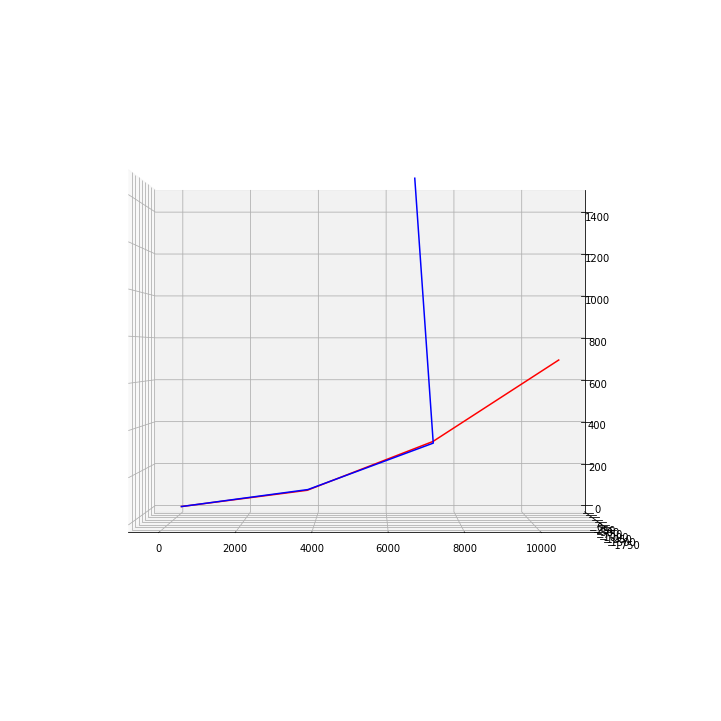

In [186]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]
# for j in range(len(fin.y.T)):
j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
ax.view_init(-30,-30)
ax.view_init(0,-90)
# ax.view_init(-90,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [187]:
X,Y,Z

(array([   0.        , 3705.81078026, 7376.67145557, 6706.01441561]),
 array([ 0.00000000e+00,  1.01075842e-04,  3.37127875e-01, -1.85740903e+03]),
 array([   0.        ,   80.4954531 ,  300.55728487, 1475.11078482]))

In [188]:
X0,Y0,Z0

(array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446]),
 array([0., 0., 0., 0.]),
 array([  0.        ,  77.06804645, 308.4070593 , 694.42189511]))

In [189]:
us=fin.T

In [190]:
# t=np.arange(tspan[0],tspan[1],tspan[1]/len(us.T))

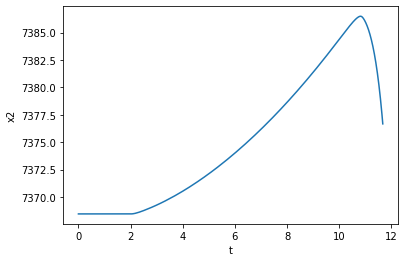

In [191]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

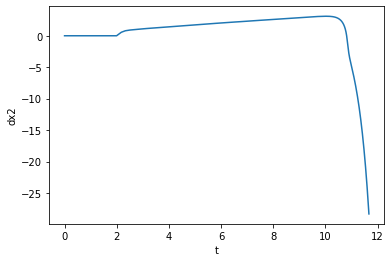

In [192]:
plt.plot(t,us.T[:,6] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

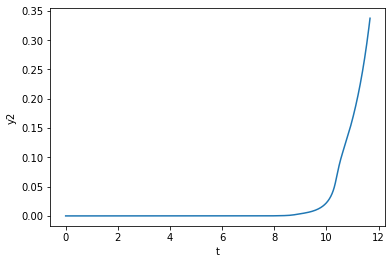

In [193]:
plt.plot(t,us.T[:,10] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

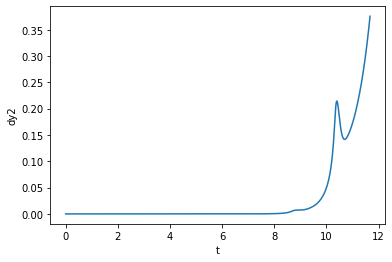

In [194]:
plt.plot(t,us.T[:,14] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

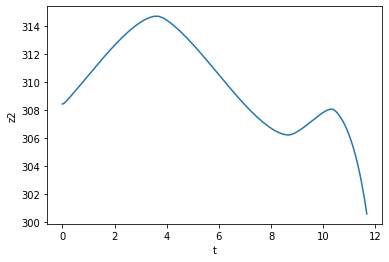

In [195]:
plt.plot(t,us.T[:,18] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

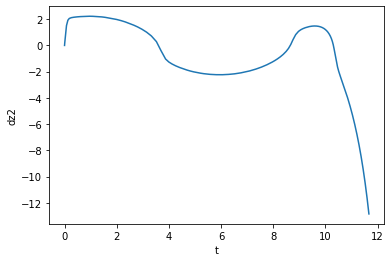

In [196]:
plt.plot(t,us.T[:,22] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

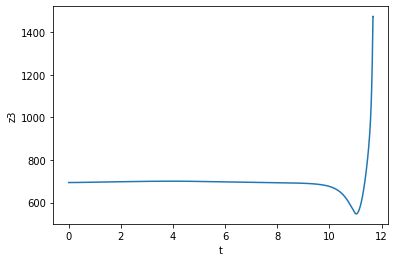

In [197]:
plt.plot(t,us.T[:,19] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

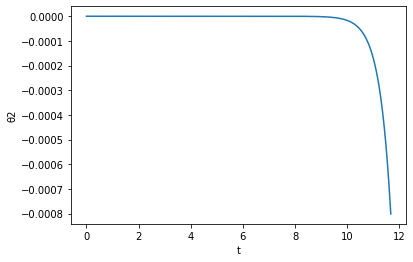

In [198]:
plt.plot(t,us.T[:,34],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

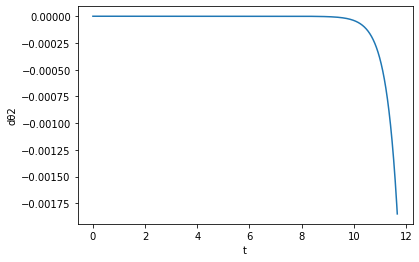

In [199]:
plt.plot(t,us.T[:,38] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

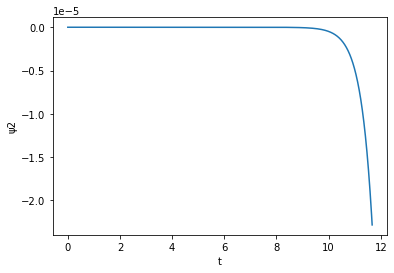

In [200]:
plt.plot(t,us.T[:,42],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

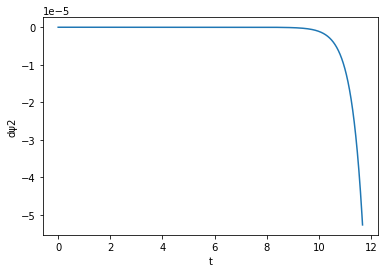

In [201]:
plt.plot(t,us.T[:,46] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()